## File Upload

Upload all the following files before running the codes: 
1. Input Files (census, cd, and enumeration details) 
2. Supportive Files (in the folders Disambiguation and Interpolation) 

## Install Requirements

In [1]:
%%capture

# Install txtai and elasticsearch python client
!pip install git+https://github.com/neuml/txtai elasticsearch

# Download and extract elasticsearch
!wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.8.1-linux-x86_64.tar.gz
!tar -xzf elasticsearch-7.8.1-linux-x86_64.tar.gz
!chown -R daemon:daemon elasticsearch-7.8.1


In [2]:
# install requirements
!pip install elasticsearch
!pip install metaphone
!pip install pyjarowinkler
!pip install python-Levenshtein
!pip install python-dateutil

!pip install pyjarowinkler
!pip install haversine
!pip install hdbscan

!pip install category_encoders
!pip install kmodes

     |████████████████████████████████| 6.4 MB 4.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp37-cp37m-linux_x86_64.whl size=2311886 sha256=31ede7dab18bfcd1adf465b517ea6f5760f02386948e587216256c9ce4b43bc7
  Stored in directory: /root/.cache/pip/wheels/73/5f/2f/9a259b84003b84847c259779206acecabb25ab56f1506ee72b
Successfully built hdbscan
     |████████████████████████████████| 82 kB 257 kB/s 


In [29]:
# Import packages for future implementation
from elasticsearch import Elasticsearch
from argparse import ArgumentParser
import csv,time,logging, json
import pandas as pd
import numpy as np
from elasticsearch import helpers
from metaphone import doublemetaphone
from elasticsearch import exceptions

import os
import sys
from subprocess import Popen, PIPE, STDOUT



module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from __init_disambiguation__ import Disambiguator
import confidence_score_tuning as cf
import processing as dp
import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import dataprocessing
import sequences as sq
import interpolation
from __init_interpolation__ import CensusData
import disambiguation_analysis as da

import interpolation_fillin
from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBClassifier
from sklearn.cluster import KMeans

from __init_interpolation__ import CentroidInterpolator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Initial Matching (ES) 
### Run through the Data

In [4]:
# Start and wait for server (ES)
server = Popen(['elasticsearch-7.8.1/bin/elasticsearch'], stdout=PIPE, stderr=STDOUT, preexec_fn=lambda: os.setuid(1))
!sleep 45

In [5]:
# Enter correct file paths in this section 
# Get statistics about each csv files
cd_file_path = "cd_1850_mn.csv"
census_file_path = "census_1850_mn_20200921.csv"
cd_file = pd.read_csv(cd_file_path)
census_file = pd.read_csv(census_file_path)
print("Number of rows in the cd file: ", len(cd_file))
print("Number of rows in the census file: ", len(census_file))
print("Columns in the cd file: ", cd_file.columns.tolist())
print("Columns in the census file: ", census_file.columns.tolist())

config_file_path = "config_1850_mn.json"

Number of rows in the cd file:  57120
Number of rows in the census file:  515630
Columns in the cd file:  ['CD_RECORD_ID', 'CD_INDEX', 'UID', 'CD_OCCUPATION', 'CD_F_LAST_NAME', 'CD_F_FIRST_NAME', 'CD_MIDDLE_NAME', 'CD_X', 'CD_Y', 'CD_H_ADDRESS', 'CD_H_HOUSE_NUMBER', 'CD_H_STREET_NAME', 'BOROUGH', 'CD_WARD_NUM', 'UW', 'CD_BLOCK_NUM', 'CD_STREET_ID']
Columns in the census file:  ['CENSUS_INDEX', 'CENSUS_IPUMS_UID', 'CENSUS_SERIAL', 'CENSUS_HH_NUM', 'CENSUS_SEQ_NUM', 'CENSUS_REEL', 'CENSUS_PAGENUM', 'CENSUS_LINE', 'CENSUS_AGE', 'CENSUS_GENDER', 'CENSUS_MARST', 'CENSUS_RACE', 'CENSUS_LABFORCE', 'CENSUS_IMPREL', 'CENSUS_OCCUPATION', 'CENSUS_FIRST_NAME', 'CENSUS_LAST_NAME', 'CENSUS_CITY', 'CENSUS_WARD_NUM', 'CENSUS_DWELLING_NUM', 'CENSUS_DWELLING_SEQ', 'CENSUS_DWELLING_SIZE', 'CENSUS_GEOG']


In [6]:
cd_file.head(3)

,CD_RECORD_ID,CD_INDEX,UID,CD_OCCUPATION,CD_F_LAST_NAME,CD_F_FIRST_NAME,CD_MIDDLE_NAME,CD_X,CD_Y,CD_H_ADDRESS,CD_H_HOUSE_NUMBER,CD_H_STREET_NAME,BOROUGH,CD_WARD_NUM,UW,CD_BLOCK_NUM,CD_STREET_ID
0,BK_1850_ADDISON_ACKLEY_1,1,100001,clerk,Ackley,Addison,NaN,-74.012274,40.703349,39 PEARL ST,39.0,PEARL,1,1,m01,m00013,G00000192
1,BK_1850_JOHN_ANDERSON_2,2,100007,seaman,Anderson,John,R,-73.981991,40.722995,586 E 4 ST,586.0,E 4,1,11,m11,m00618,G00002795
2,BK_1850_JOHN_APPELL_3,3,100010,tailor,Appell,John,NaN,-73.980306,40.721984,40 C AVE,40.0,C AVE,1,11,m11,m00586,G00006067


In [7]:
census_file.head(3)

,CENSUS_INDEX,CENSUS_IPUMS_UID,CENSUS_SERIAL,CENSUS_HH_NUM,CENSUS_SEQ_NUM,CENSUS_REEL,CENSUS_PAGENUM,CENSUS_LINE,CENSUS_AGE,CENSUS_GENDER,CENSUS_MARST,CENSUS_RACE,CENSUS_LABFORCE,CENSUS_IMPREL,CENSUS_OCCUPATION,CENSUS_FIRST_NAME,CENSUS_LAST_NAME,CENSUS_CITY,CENSUS_WARD_NUM,CENSUS_DWELLING_NUM,CENSUS_DWELLING_SEQ,CENSUS_DWELLING_SIZE,CENSUS_GEOG
0,1,1a0cea81-aa4c-4e02-af29-37f3fdadd987,2044262,401735,1,534,70,10,49,1,6,120,2,1,INN KEEPER,JOHN M,FLINT,MANHATTAN,1,1.0,1.0,84,NEW YORK WARD 1 EASTERN DIVISION
1,2,29aed4d0-b649-4d6b-9e28-3db8f4da81d8,2044263,401735,2,534,70,10,36,2,6,120,0,1,NaN,MARY A,FLINT,MANHATTAN,1,1.0,1.0,84,NEW YORK WARD 1 EASTERN DIVISION
2,3,8cfac447-5fdf-44a4-888c-ee1c7e2a8355,2044264,401735,3,534,70,10,12,2,6,120,0,1,NaN,MARY D,FLINT,MANHATTAN,1,1.0,1.0,84,NEW YORK WARD 1 EASTERN DIVISION


In [8]:
import re
es = Elasticsearch(hosts=["http://localhost:9200"], timeout=60, retry_on_timeout=True)

logging.basicConfig(filename="/content/bulk_insert.log",
                            filemode='a',
                            format='%(asctime)s %(name)s %(message)s',
                            datefmt='%H:%M:%S',
                            level=logging.WARNING)
logger = logging.getLogger('InsertTime')

def ingest(config):
    df = pd.read_csv(config['census_filename'])
    bulk_data = []
    count = 0 
    for itr, row in df.iterrows():
        count+=1
        row = row.replace(np.nan,'',regex=True) #covnert nan to empty string
        data = row.to_dict() #converts the dataframe row to dictonary with their correct data type
        if 'LOCATION' in data:
          data['LOCATION'] = {"lat":data["LAT"],"lon":data["LONG"]} # find location
        
        if 'ADDNUMFROM' in data and type(data['ADDNUMFROM']) is str:
            data['ADDNUMFROM'] = data['ADDNUMFROM'].replace('`','')

        data[config['census_first_name']] = name_clean(data[config['census_first_name']])
        data[config['census_last_name']] = name_clean(data[config['census_last_name']])

        if config['metaphone'] is 1: # default metaphone is 1
          first_name_meta = [i for i in doublemetaphone(data[config['census_first_name']]) if i]
          last_name_meta = [i for i in doublemetaphone(data[config['census_last_name']]) if i]
          data['METAPHONE_NAMEFIRST'] = first_name_meta
          data['METAPHONE_NAMELAST'] = last_name_meta

        if id is not False:
          meta = {
              "_index": config['es-index'],
              "_id": data[config['es-id']],
              "_source": data
          }
        else:
          meta = {
              "_index": config['es-index'],
              "_source": data
          }

        bulk_data.append(meta)
        if itr%config['ingest_size'] == 0:
            helpers.bulk(es, bulk_data)
            bulk_data = []
            print("INSERTING NOW", itr)
            
    helpers.bulk(es, bulk_data)
    return count

def name_clean(name):
  name = max(name.split(' '), key=len) # remove middle name if any
  name = re.sub('[^A-Za-z0-9]+', '', name)
   
  return name

if __name__=='__main__':
    if __name__ == '__main__':
      with open(config_file_path) as json_data_file:
         config = json.load(json_data_file)

      st = time.time()
      count= ingest(config)
      print("Total number of records in the census data is: ", count)
      end = time.time()
      logger.warning(config["es-index"] +" "+ str(end-st))
      
# Total run time: 4m39s

INSERTING NOW 0
INSERTING NOW 5000
INSERTING NOW 10000
INSERTING NOW 15000
INSERTING NOW 20000
INSERTING NOW 25000
INSERTING NOW 30000
INSERTING NOW 35000
INSERTING NOW 40000
INSERTING NOW 45000
INSERTING NOW 50000
INSERTING NOW 55000
INSERTING NOW 60000
INSERTING NOW 65000
INSERTING NOW 70000
INSERTING NOW 75000
INSERTING NOW 80000
INSERTING NOW 85000
INSERTING NOW 90000
INSERTING NOW 95000
INSERTING NOW 100000
INSERTING NOW 105000
INSERTING NOW 110000
INSERTING NOW 115000
INSERTING NOW 120000
INSERTING NOW 125000
INSERTING NOW 130000
INSERTING NOW 135000
INSERTING NOW 140000
INSERTING NOW 145000
INSERTING NOW 150000
INSERTING NOW 155000
INSERTING NOW 160000
INSERTING NOW 165000
INSERTING NOW 170000
INSERTING NOW 175000
INSERTING NOW 180000
INSERTING NOW 185000
INSERTING NOW 190000
INSERTING NOW 195000
INSERTING NOW 200000
INSERTING NOW 205000
INSERTING NOW 210000
INSERTING NOW 215000
INSERTING NOW 220000
INSERTING NOW 225000
INSERTING NOW 230000
INSERTING NOW 235000
INSERTING NOW 240

Finding match on all conditions: first name, last name, Ward no, metaphones

In [9]:
with open(config_file_path) as json_data_file:
    config = json.load(json_data_file)

es = Elasticsearch(host=config['host'], port=config['port'])

def match_addr():
    df = pd.read_csv(config['cd_filename'])
    count, match,unmatch = 0,0,0
    with open(config['match_output_filename'],'w') as fw, open(config['unmatch_output_filename'],'w') as fw2:
        writer = csv.writer(fw, delimiter="\t",quotechar='"')
        columns = config["output_census_cols"] + config["output_city_directory_cols"]
        rows=""
        for cols in columns:
            rows = rows + cols + "\t"
        
        writer.writerow(rows.rstrip("\t").split("\t"))
        for index, row in df.iterrows():
            count += 1
            row = row.replace(np.nan,'',regex=True) #covnert nan to empty string
            data = row.to_dict()
            
            # clean the last_name field of data (Remove the component of "Van" in some records)
            data['CD_F_LAST_NAME'] = name_clean(data['CD_F_LAST_NAME'])


            first_name_metaphone = [i for i in doublemetaphone(data["CD_F_FIRST_NAME"]) if i]
            last_name_metaphone = [i for i in doublemetaphone(data["CD_F_LAST_NAME"]) if i]

            if config['edit_distance'] !=0:
                if config['metaphone'] is 1:
                    query = { "bool" : { "must" : [{ "fuzzy": { "CENSUS_FIRST_NAME": { "value": data["CD_F_FIRST_NAME"], "fuzziness": config["edit_distance"], "max_expansions": 50, "prefix_length": 0, "transpositions": True, "rewrite": "constant_score" } } },
                            {"fuzzy": { "CENSUS_LAST_NAME": { "value": data["CD_F_LAST_NAME"], "fuzziness": config["edit_distance"], "max_expansions": 50, "prefix_length": 0, "transpositions": True, "rewrite": "constant_score" } }},
                            { "match" : { "CENSUS_WARD_NUM": data["CD_WARD_NUM"]} },
                            {"terms": {"METAPHONE_NAMELAST.keyword": last_name_metaphone}},
                            {"terms": {"METAPHONE_NAMEFIRST.keyword": first_name_metaphone}}]}}

                else:
                    query = { "bool" : { "must" : [{ "fuzzy": { "CENSUS_FIRST_NAME": { "value": data["CD_F_FIRST_NAME"], "fuzziness": config["edit_distance"], "max_expansions": 50, "prefix_length": 0, "transpositions": True, "rewrite": "constant_score" } } },
                            {"fuzzy": { "CENSUS_LAST_NAME": { "value": data["CD_F_LAST_NAME"], "fuzziness": config["edit_distance"], "max_expansions": 50, "prefix_length": 0, "transpositions": True, "rewrite": "constant_score" } }},
                            { "match" : { "CENSUS_WARD_NUM": data["CD_WARD_NUM"]} }]}}
            

            if config['edit_distance'] is 0:
                if config['metaphone'] is 1:
                   query =  { "bool" : { "must" : [{ "match": { "CENSUS_FIRST_NAME": data["CD_F_FIRST_NAME"] } },
                            { "match": { "CENSUS_LAST_NAME": data["CD_F_LAST_NAME"] } },
                            { "match" : { "CENSUS_WARD_NUM": data["CD_WARD_NUM"]} },
                            {"terms": {"METAPHONE_NAMELAST.keyword": last_name_metaphone}},
                            {"terms": {"METAPHONE_NAMEFIRST.keyword": first_name_metaphone}}]}}
            
                else:
                    query = { "bool" : { "must" : [{ "match": { "CENSUS_FIRST_NAME": data["CD_F_FIRST_NAME"] } },
                            { "match": { "CENSUS_LAST_NAME": data["CD_F_LAST_NAME"] } },
                            { "match" : { "CENSUS_WARD_NUM": data["CD_WARD_NUM"]}}]}}

            
            try:
                res = es.search(index=config["es-index"], body={ "from": 0, "size": 10000, "query":query})
            except exceptions.RequestError:
                print("Exception at row id: ", index)
                continue
            
            if res['hits']['total']['value']!= 0:
                for i in res['hits']['hits']:
                    i = i['_source']
                    content = ""
                    for j in config["output_census_cols"]:
                        content = content + str(i[j]) + "\t"

                    for j in config["output_city_directory_cols"]:
                        content = content + str(data[j]) + "\t"

                    writer.writerow(content.rstrip("\t").split("\t"))
                    match+=1
            else:
                fw2.write(str(data['CD_RECORD_ID'])+"\n")
                unmatch+=1
        
    print(count,match,unmatch)

if __name__=='__main__':
    st = time.time()
    match_addr()
    end = time.time()
    print(config["es-index"] +" "+ str(end-st))

# Total running time: 6m-7m


57120 60748 33364
mn-census-1850 471.39340901374817


In [10]:
match_test_file = pd.read_csv("test_mn.csv", error_bad_lines=False, sep = "\t")
print("Number of unique cd record matched:", match_test_file['CD_RECORD_ID'].nunique())
print("Proportion of cd matched record: ", match_test_file['CD_RECORD_ID'].nunique()/len(cd_file))

Number of unique cd record matched: 23756
Proportion of cd matched record:  0.4158963585434174


The proportion of matching with the updated 1850 MN files is lower than the previous record (43.4%). 

### Initial Disambiguation

Upload the files in the Disambiguation folder for following steps. 

In [11]:
# Initial Disambiguation
elastic_search_file = "test_mn.csv"
elastic_match = pd.read_csv(elastic_search_file, sep='\t', engine='python')

In [12]:
match_file = "1850_mn_match.csv"

# Unique id in the cd data is CD_RECORD_ID
elastic_match = dp.col_for_disamb(elastic_match, cd_id = "CD_RECORD_ID",cen_id = "CENSUS_IPUMS_UID")

elastic_match.loc[:,"confidence_score"] = cf.confidence_score(elastic_match, ['jw_score','cd_count_inverse','census_count_inverse', 'occ_listed', 'age_score'], [0.7,0.1,0.1,0.05,0.05])

print ("No. of matches: " + str(len(elastic_match)))
print ("No. of unique CD records: " + str(len(elastic_match['CD_RECORD_ID'].drop_duplicates())))
print ("No. of unique Census records: " + str(len(elastic_match['CENSUS_IPUMS_UID'].drop_duplicates())))
print ("No. of 1:1 matches: " + str(len(elastic_match[ (elastic_match['census_count'] == 1) & (elastic_match['cd_count'] == 1) ] )) )
print ("No. of matches where census record age <= 12: " + str( len(elastic_match[elastic_match['CENSUS_AGE'] <= 12]) ))
print ("No. of unique matches where census record age <= 12: " + str( len(elastic_match[elastic_match['CENSUS_AGE'] <= 12]['CENSUS_IPUMS_UID'].drop_duplicates()) ))
print ("No. of anchors (confidence score = 1): " + str( len(elastic_match[elastic_match['confidence_score'] == 1]) ))

disambiguate = Disambiguator(elastic_match, lon='CD_X', lat='CD_Y',sort_var='CENSUS_INDEX')
disambiguate.run_disambiguation()

result = disambiguate.get_result()

print("records with a final match:", sum(result.selected))
print("all records matched:", len(result))
print("number of cd records matched:", len(result['CD_ID'].drop_duplicates()))
print("proportion of cd records in elastic search included in final match:", sum(result.selected) / len(result['CD_ID'].drop_duplicates()))

result.to_csv(match_file, index=False)

# Wall Clock: 5m 13s 

No. of matches: 60748
No. of unique CD records: 23756
No. of unique Census records: 44162
No. of 1:1 matches: 11113
No. of matches where census record age <= 12: 14417
No. of unique matches where census record age <= 12: 10044
No. of anchors (confidence score = 1): 6087
Running
Creating dictionary of sub dfs (1/4)...
Applying algorithms iteratively (2/4)...
Number of Subgraphs: 6087
Reached: 0
Reached: 1000
Reached: 2000
Reached: 3000
Reached: 4000
Reached: 5000
Reached: 6000
Cleaning output (3/4)...
Disambiguating (4/4)...
Total time: 264.9877107143402
Done! :)
records with a final match: 23116.0
all records matched: 60748
number of cd records matched: 23756
proportion of cd records in elastic search included in final match: 0.9730594376157602


### Disambiguation with Dwelling Number and Interpolation

In [13]:
# output file
census_filled_file = "dwelling_filled_sum_1850_mn_20211022.csv"

# input file
census = pd.read_csv("census_1850_mn_20200921.csv")
disambiguation = pd.read_csv("1850_mn_match.csv")
city_directory = pd.read_csv("cd_1850_mn.csv")

In [14]:
ward_col = "CENSUS_WARD_NUM"
dwelling_col = "dwelling_id"
block_col = "CD_BLOCK_NUM"
cd_ward_col = "CD_WARD_NUM"
cd_block_col = "CD_BLOCK_NUM"
dwelling_num_col = "CENSUS_DWELLING_NUM"
cd_address = "CD_H_ADDRESS"
pagenum = "CENSUS_PAGENUM"
x_col = "CD_X"
y_col = "CD_Y"

In [15]:
census_disamb = da.add_disamb_census(disambiguation, census, disamb_columns = ["CENSUS_IPUMS_UID", "CD_H_ADDRESS", "CD_BLOCK_NUM","CD_X", "CD_Y", "spatial_weight", "CD_STREET_ID"], disamb_id = "CENSUS_IPUMS_UID")

In [16]:
print("City directory match rate:", disambiguation["selected"].sum()/len(city_directory))
print("Census record match rate:", da.get_match_rate(census_disamb, name = cd_address))

City directory match rate: 0.4046918767507003
Census record match rate: 0.04483059558210345


In [17]:
print("Census record match rate broken down by ward")
da.get_ward_match(census_disamb, name = cd_address, ward_col = ward_col)

Census record match rate broken down by ward
Ward  1 :  0.02981
Ward  2 :  0.03171
Ward  3 :  0.0419
Ward  4 :  0.04173
Ward  5 :  0.06145
Ward  6 :  0.03122
Ward  7 :  0.04601
Ward  8 :  0.0549
Ward  9 :  0.05876
Ward  10 :  0.06759
Ward  11 :  0.03714
Ward  12 :  0.00019
Ward  13 :  0.06359
Ward  14 :  0.04461
Ward  15 :  0.04702
Ward  16 :  0.04546
Ward  17 :  0.05438
Ward  18 :  0.03056
Ward  19 :  0.00103


In [18]:
#create unique dwelling id
census_disamb = census_disamb.groupby(ward_col, as_index = False).apply(lambda x: dataprocessing.create_unique_dwelling(x, dwelling_num_col))

In [19]:
census_disamb.columns

Index(['CENSUS_INDEX', 'CENSUS_IPUMS_UID', 'CENSUS_SERIAL', 'CENSUS_HH_NUM',
       'CENSUS_SEQ_NUM', 'CENSUS_REEL', 'CENSUS_PAGENUM', 'CENSUS_LINE',
       'CENSUS_AGE', 'CENSUS_GENDER', 'CENSUS_MARST', 'CENSUS_RACE',
       'CENSUS_LABFORCE', 'CENSUS_IMPREL', 'CENSUS_OCCUPATION',
       'CENSUS_FIRST_NAME', 'CENSUS_LAST_NAME', 'CENSUS_CITY',
       'CENSUS_WARD_NUM', 'CENSUS_DWELLING_NUM', 'CENSUS_DWELLING_SEQ',
       'CENSUS_DWELLING_SIZE', 'CENSUS_GEOG', 'CD_H_ADDRESS', 'CD_BLOCK_NUM',
       'CD_X', 'CD_Y', 'spatial_weight', 'CD_STREET_ID', 'dwelling_id'],
      dtype='object')

**Problem:** Disambiguation matched city directory and census records which represent individual people. Sometimes, people who lived in the same dwelling were assigned different addresses. How do we assign dwellings with address conflicts from disambiguation a single address?\
**Solution:** Use spatial weight created from disambiguation process and select address with the largest some of spatial weights\
**Reasoning:**
1. When disambiguating looking for similarity between individuals makes use of available information, and seems more likely to be accurate as a result. Any construction of dwelling similarity seems much weaker. Creating the final match with bipartite matching is an elegant approach that won't work on the dwelling level because different dwellings can be assigned the same address
2. Using the sum of spatial weights gives more weight to an address that is assigned multiple times within a dwelling

**Remaining Questions:**
1. When there's a tie in sum of spatial weight the process simply selects first option. This is consistent with the disambiguation approach to this solution. Can we create a more rigorous approach to resolving ties?

For more detail about exploration of this problem and solutions: [Dwelling Sequences.ipynb](https://github.com/CenterForSpatialResearch/hnyc-spatial-linkage/blob/spatial_linkage/tks/Interpolation/Dwelling%20Addresses.ipynb)

In [20]:
total_num_dwellings = census_disamb.groupby([ward_col, dwelling_col]).ngroups
conflicts_info = da.get_counts(census_disamb, ward_col = ward_col, dwelling_col = dwelling_col, address = cd_address)
print("Proportion of dwelling records with single address match:", round(sum(conflicts_info["single_address"][0].values())/total_num_dwellings, 5))
print("Proportion of dwelling records with multiple address matches:",round(sum(conflicts_info["multiple_addresses"][0].values())/total_num_dwellings, 5))
print("Proportion of dwelling records without any match:", round(sum(conflicts_info["no_address"][0].values())/total_num_dwellings, 5))
print("Proportion of dwellings with address after resolving conflicts:", round((sum(conflicts_info["single_address"][0].values()) + sum(conflicts_info["multiple_addresses"][0].values()))/total_num_dwellings, 5))
print("Proportion of census records with single address match:", round(conflicts_info["single_address"][1]/len(census_disamb), 5))
print("Proportion of census records with multiple address matches:",round(conflicts_info["multiple_addresses"][1]/len(census_disamb), 5))
print("Proportion of census records without any match:", round(conflicts_info["no_address"][1]/len(census_disamb), 5))
print("Proportion of census records with address after resolving conflicts:", round((conflicts_info["single_address"][1] + conflicts_info["multiple_addresses"][1])/len(census_disamb), 5))

Proportion of dwelling records with single address match: 0.31527
Proportion of dwelling records with multiple address matches: 0.09144
Proportion of dwelling records without any match: 0.59328
Proportion of dwellings with address after resolving conflicts: 0.40672
Proportion of census records with single address match: 0.34816
Proportion of census records with multiple address matches: 0.17233
Proportion of census records without any match: 0.47951
Proportion of census records with address after resolving conflicts: 0.52049


In [21]:
ward_dwelling_conflict_info = pd.DataFrame([x[0] for x in conflicts_info.values()], index=[key for key in conflicts_info]).T
ward_dwelling_conflict_info.fillna(0, inplace = True)
ward_dwelling_conflict_info = ward_dwelling_conflict_info.transform(lambda x: x / x.sum(), axis = 1)
ward_dwelling_conflict_info["with_address"] = ward_dwelling_conflict_info["single_address"] + ward_dwelling_conflict_info["multiple_addresses"]

In [22]:
print("Ward break down of dwelling proportions")
display(ward_dwelling_conflict_info)

Ward break down of dwelling proportions


,no_address,single_address,multiple_addresses,with_address
1,0.636279,0.267907,0.095814,0.363721
2,0.763077,0.190769,0.046154,0.236923
3,0.603283,0.317373,0.079343,0.396717
4,0.526742,0.327391,0.145867,0.473258
5,0.523221,0.384881,0.091897,0.476779
6,0.602994,0.319316,0.077691,0.397006
7,0.584763,0.321899,0.093339,0.415237
8,0.514931,0.377640,0.107429,0.485069
9,0.535776,0.356039,0.108185,0.464224
10,0.463659,0.432080,0.104261,0.536341


In [23]:
#Resolve dwelling conflicts
census_filled = census_disamb.groupby([ward_col, dwelling_col]).apply(lambda x: da.dwelling_weight_fill(x, address = cd_address, block_col = block_col))
#Add in values dropped because they don't have a dwelling number
census_filled = pd.concat([census_filled, census_disamb[census_disamb[dwelling_col].isnull()]], sort= True)
census_filled.reset_index(drop = True, inplace = True)
census_filled.to_csv(census_filled_file, index = False)
# Wall Clock: 1m31s

In [24]:
census_filled_dwellings = census_filled.groupby([ward_col, dwelling_col], as_index = False).first()
print("Census record match rate:", da.get_match_rate(census_filled, name = cd_address))
print("Dwelling record match rate:", da.get_match_rate(census_filled_dwellings, name = cd_address))

Census record match rate: 0.5204856195333863
Dwelling record match rate: 0.4067168049792531


# Interpolation of block number and sequences

* Run this notebook to proceed the interpolation steps
* Its input is output from the disambiguation process
* Its output (record-level) will be fed into the model phase.

**Summary of the interpolation process**
1. merge census and enumeration files
2. create the sequences
3. fill in block number column
4. fill in distance sequence and enumeration distance sequence columns

### Notes

1. **`dataprocessing.all_dwellings_sequenced` creates helper columns that should be removed once finished. Otherwise, errors may occur when recalling the function or merging dfs.**

2. The output file info:
    * currently based on files [see setup]
    * dwelling level, 1850
    * **block number** is filled in, looking at **distance** and **enumeration distance** sequences. Restriction is adjustable.
    * **distance** and **enumeration distance** sequences are filled in, looking at **block cluster**
    * No data on ward 12 (no address data to work with) and ward 19 for Manhattan data(error at kmeans that I have not had a chance to look at.)

# 1. Setup


* Read in datasets and set column names

In [26]:
# Output file
output_file_path = 'census_interpolated_1850_mn_20211022.csv'

# Input file
filled_1850 = pd.read_csv("dwelling_filled_sum_1850_mn_20211022.csv")
cd_1850 = pd.read_csv("cd_1850_mn.csv")
enumerators = pd.read_csv("census_1850_enumerationDetail_mn.csv")

filled_1850['CENSUS_PAGENUM'] = filled_1850['CENSUS_PAGENUM']//10

In [27]:
enumerators.head(3)

,PLACE,CENSUS_PAGENNO,CENSUS_WARD_NUM,CENSUS_ENUMERATOR_NUM,CENSUS_ENUMERATOR_DATE,ANCESTRY_REF,Notes,CENSUS_PAGENO_HOUSEHOLD,CENSUS_REEL_HOUSEHOLD
0,Ward 1 Eastern Division,7,1,e01,1850/09/12,4189775,NaN,70,NaN
1,Ward 1 Eastern Division,8,1,e01,1850/09/12,4189775,NaN,80,NaN
2,Ward 1 Eastern Division,9,1,e01,1850/09/12,4189775,NaN,90,NaN


#### Merge census and enumeration files

In [28]:
census_enumerators = interpolation_fillin.merge_census_enumeration(filled_1850,
                                                                   enumerators, 
                                                                   ward_col, pagenum, 
                                                                   ward_col, 'CENSUS_PAGENNO')

#### Generate Sequences

In [30]:
census_enum_seq = CensusData(census_enumerators, ward_col=ward_col, dwelling_col=dwelling_col, 
                             block_col =  block_col, x_col = x_col, y_col = y_col, pagenum = pagenum)
#census_enum_seq.apply_sequencing(enumerator_dist = True, dwelling = True, 
#                                 fixed = True, distance = True, d=0.2)
# Generate sequence of enumerators in a single day

sequences_dfs = census_enum_seq.applying_sequencing_only_enum()


# Wall Clock: 23s


In [31]:
# Sequence id dictionary generation 
sequences_dfs_simple = sequences_dfs[['CENSUS_ENUMERATOR_NUM', 'CENSUS_ENUMERATOR_DATE', "enum_seq"]]
sequences_dfs_simple = sequences_dfs_simple.drop_duplicates(subset=['enum_seq'], keep = "first")
sequence_id_dict = sequences_dfs_simple.set_index(["CENSUS_ENUMERATOR_NUM", "CENSUS_ENUMERATOR_DATE"]).stack().to_dict()

In [32]:
sequence_unique_id = "enum_seq"

When using the enumerator's daily record as the sequence identification, we use 'enum_seq' as the identifier. 

### Visualize the resulted sequences

In [33]:
def get_cmap(n, name='hsv'):
    return plt.cm.get_cmap(name, n)

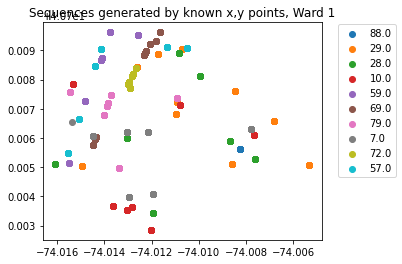

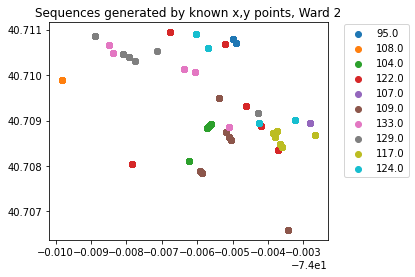

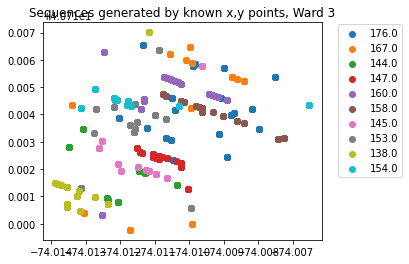

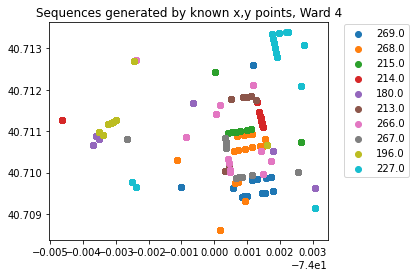

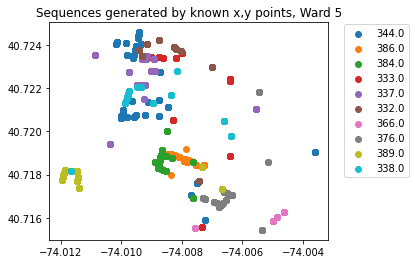

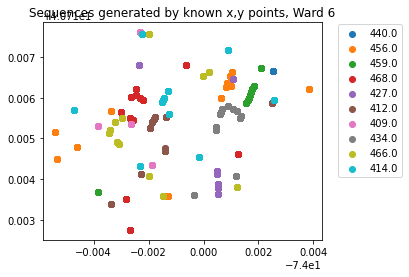

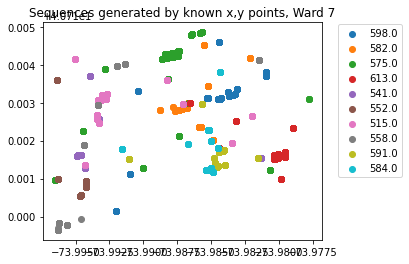

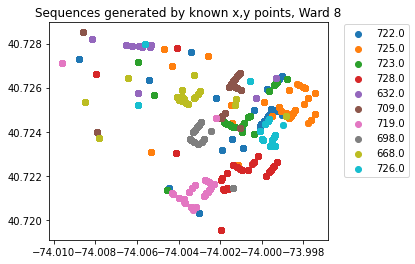

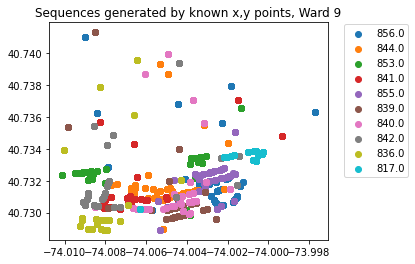

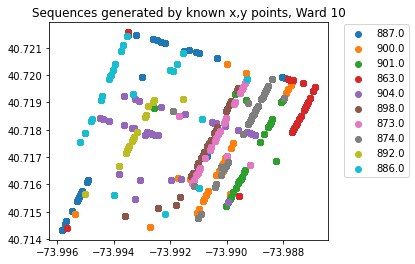

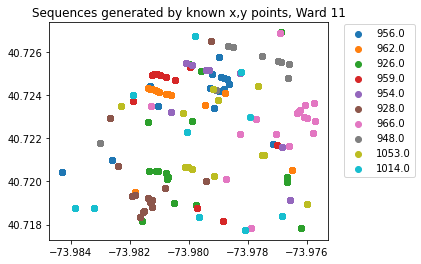

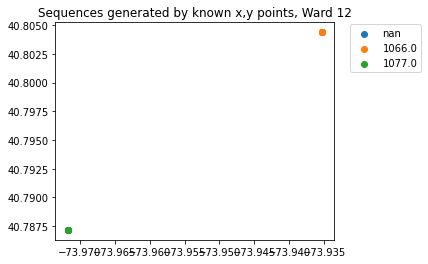

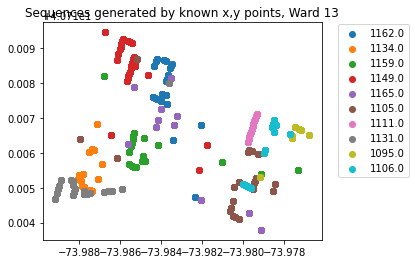

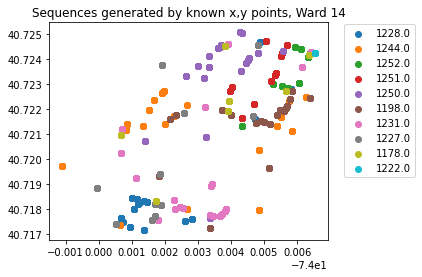

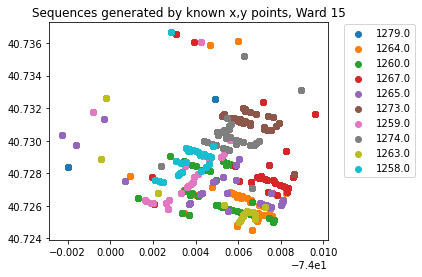

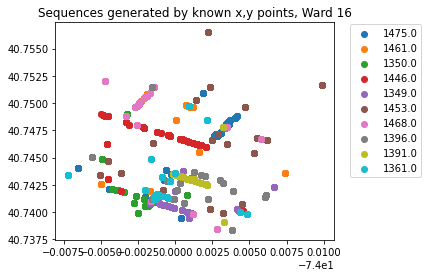

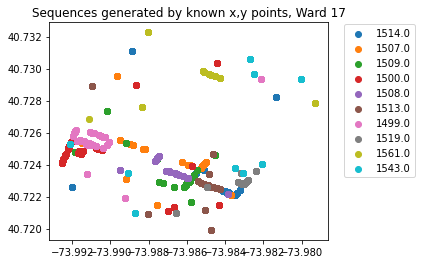

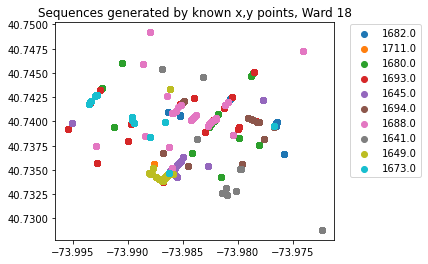

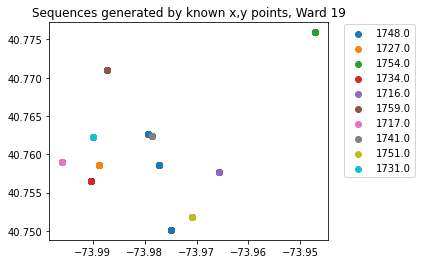

In [34]:
input_df = census_enum_seq.df
num_enumerator = 10
for ward in input_df[ward_col].unique():
    fig,ax = plt.subplots(1,1, figsize = (5,4))
    dwellings_w = input_df[input_df[ward_col] == ward]
    
    if dwellings_w[sequence_unique_id].nunique() <= num_enumerator:
        sequences = dwellings_w[sequence_unique_id].unique()
    else:
        sequences_count = dwellings_w.groupby(sequence_unique_id).count().\
                        sort_values(['CD_BLOCK_NUM'], ascending=False).\
                        reset_index()
        sequences = sequences_count[sequence_unique_id][0:num_enumerator]
    colors = [plt.rcParams['axes.prop_cycle'].by_key()['color'][x] for x in range(len(sequences))]
    #colors = get_cmap(num_enumerator)
    #colors = [colors(i) for i in range(num_enumerator)]
    
    for sequence, color in zip(sequences, colors):
        dwelling_seq = dwellings_w[dwellings_w[sequence_unique_id] == sequence]
        ax.scatter(dwelling_seq["CD_X"], dwelling_seq["CD_Y"], label = sequence, color = color)
        ax.scatter(dwelling_seq["CD_X"], dwelling_seq["CD_Y"], s = 2, color = color)
    ax.set_title("Sequences generated by known x,y points, Ward "+str(ward))
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.2)

#### 2. Fill in block number

By checking `block number`, `distance sequence`, and `enumeration distance sequence`

In [35]:
census_enum_seq.df.columns
# only enumerator

Index(['CD_BLOCK_NUM', 'CD_H_ADDRESS', 'CD_STREET_ID', 'CD_X', 'CD_Y',
       'CENSUS_AGE', 'CENSUS_CITY', 'CENSUS_DWELLING_NUM',
       'CENSUS_DWELLING_SEQ', 'CENSUS_DWELLING_SIZE', 'CENSUS_FIRST_NAME',
       'CENSUS_GENDER', 'CENSUS_GEOG', 'CENSUS_HH_NUM', 'CENSUS_IMPREL',
       'CENSUS_INDEX', 'CENSUS_IPUMS_UID', 'CENSUS_LABFORCE',
       'CENSUS_LAST_NAME', 'CENSUS_LINE', 'CENSUS_MARST', 'CENSUS_OCCUPATION',
       'CENSUS_PAGENUM', 'CENSUS_RACE', 'CENSUS_REEL', 'CENSUS_SEQ_NUM',
       'CENSUS_SERIAL', 'CENSUS_WARD_NUM', 'dwelling_id', 'spatial_weight',
       'spatial_weight_sum', 'page_sequence_id', 'PLACE',
       'CENSUS_ENUMERATOR_NUM', 'CENSUS_ENUMERATOR_DATE', 'ANCESTRY_REF',
       'CENSUS_REEL_HOUSEHOLD', 'enum_dist_id', 'enum_dist', 'enum_dist_order',
       'enum_sequence_len', 'enum_seq', 'num_between', 'dwelling_seq_id'],
      dtype='object')

In [36]:
census_all_dwellings, dwellings_sequence_with_next_info \
    = interpolation_fillin.get_dwelling_with_fillin_info(census_enum_seq, ward_col, 
                                                         dwelling_col, block_col)

In [37]:
dwellings_sequence_with_next_info.loc[dwellings_sequence_with_next_info[ward_col].isnull()].shape

(0, 47)

In [38]:
all_dwellings_3 = dataprocessing.all_dwellings_sequenced(census_all_dwellings, 
                                                         dwellings_sequence_with_next_info,
                                                         fill_column = block_col,
                                                         check_column = [block_col, sequence_unique_id, 
                                                                         sequence_unique_id], 
                                                         ward_col = ward_col, 
                                                         dwelling_col = dwelling_col)

## remove helper columns as mentioned at the top of the notebook
all_dwellings_3.drop(columns = ['header', 'CD_BLOCK_NUM_next', 'num_between_real'], 
                     inplace=True)


In [39]:
len(all_dwellings_3[all_dwellings_3['CD_BLOCK_NUM'].isnull()])/len(all_dwellings_3)

0.470954356846473

In [40]:
filled_block_num = all_dwellings_3.loc[~(all_dwellings_3['CD_BLOCK_NUM'].isnull()) & (all_dwellings_3[sequence_unique_id].isnull())].shape[0]
unknown_dwelling = all_dwellings_3.loc[(all_dwellings_3[sequence_unique_id].isnull())].shape[0]
total_dwelling = all_dwellings_3.shape[0]
print('Total Dwelling: ', total_dwelling)
print('Total Unknown Dwelling: ', unknown_dwelling)
print('Total Dwelling with filled block number: ', filled_block_num)

Total Dwelling:  38560
Total Unknown Dwelling:  22887
Total Dwelling with filled block number:  4727


#### Label dwellings whose block num is filled

label dwellings whose block number isn't provided but is available becuase of the interpolation with 1. Otherwise 0.

In [41]:
all_dwellings_3['filled_block_num'] = np.where((~all_dwellings_3[block_col].isnull()) &
                                              (all_dwellings_3[sequence_unique_id].isnull()), 1, 0)

#### Label dwellings whose address is known

label dwellings whose block number/addresses are already available with 1. Otherwise, 0. (Dwellings with known address must have distance sequence.)

In [42]:
all_dwellings_3['known_address'] = np.where(~all_dwellings_3[sequence_unique_id].isnull(), 1, 0)

## Remove ward 12 and 19

### 1850 CD wards with addresses
<img src="fig_1850_cd_wards.png" alt="." width="200"/>

There are few known dwellings in ward 12 and 19, which is too few.  These 2 wards are removed from the process.

In [43]:
all_dwellings_3 = all_dwellings_3.loc[all_dwellings_3[ward_col] != 12]
all_dwellings_3 = all_dwellings_3.loc[all_dwellings_3[ward_col] != 19]

In [44]:
all_dwellings_3

,CENSUS_WARD_NUM,dwelling_id,CD_H_ADDRESS,CD_STREET_ID,CD_X,CD_Y,CENSUS_AGE,CENSUS_CITY,CENSUS_DWELLING_NUM,CENSUS_DWELLING_SEQ,CENSUS_DWELLING_SIZE,CENSUS_FIRST_NAME,CENSUS_GENDER,CENSUS_GEOG,CENSUS_HH_NUM,CENSUS_IMPREL,CENSUS_INDEX,CENSUS_IPUMS_UID,CENSUS_LABFORCE,CENSUS_LAST_NAME,CENSUS_LINE,CENSUS_MARST,CENSUS_OCCUPATION,CENSUS_PAGENUM,CENSUS_RACE,CENSUS_REEL,CENSUS_SEQ_NUM,CENSUS_SERIAL,spatial_weight,spatial_weight_sum,page_sequence_id,PLACE,CENSUS_ENUMERATOR_NUM,CENSUS_ENUMERATOR_DATE,ANCESTRY_REF,CENSUS_REEL_HOUSEHOLD,enum_dist_id,enum_dist,enum_dist_order,enum_sequence_len,enum_seq,num_between,dwelling_seq_id,CD_BLOCK_NUM,filled_block_num,known_address
0,1,1,25 SOUTH ST,G00007787,-74.009014,40.702622,49,MANHATTAN,1.0,1.0,84,JOHN M,1,NEW YORK WARD 1 EASTERN DIVISION,401735,1,1,1a0cea81-aa4c-4e02-af29-37f3fdadd987,2,FLINT,10,6,INN KEEPER,7,120,534,1,2044262,1.9200,1.9200,0,Ward 1 Eastern Division,e01,1850/09/12,4189775.0,NaN,0.0,NaN,0.0,0.0,1.0,NaN,0.0,m00010,0,1
1,1,2,None,None,NaN,NaN,24,MANHATTAN,2.0,2.0,3,LEWIS,1,NEW YORK WARD 1 EASTERN DIVISION,401872,1,162,c9c7226f-f6d1-4d88-bfe2-d10441c95f97,2,JOHNSON,360,6,SAILOR,10,120,534,1,2044348,NaN,NaN,0,Ward 1 Eastern Division,e01,1850/09/12,4189775.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2,1,3,None,None,NaN,NaN,26,MANHATTAN,3.0,3.0,1,CHARLES,1,NEW YORK WARD 1 EASTERN DIVISION,401875,1,165,ad634efa-6ae4-4f22-9568-e9dabb4b4c4f,2,RUTGER,390,6,BOATMAN,10,120,534,1,2044349,NaN,NaN,0,Ward 1 Eastern Division,e01,1850/09/12,4189775.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
3,1,4,None,None,NaN,NaN,23,MANHATTAN,4.0,4.0,1,J B,1,NEW YORK WARD 1 EASTERN DIVISION,401876,1,166,7804c4f1-5b2e-4d70-bd1a-6d60d48c26c7,2,DICKINSON,400,6,BOATMAN,10,120,534,1,2044350,NaN,NaN,0,Ward 1 Eastern Division,e01,1850/09/12,4189775.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
4,1,5,None,None,NaN,NaN,30,MANHATTAN,5.0,5.0,3,PETER,1,NEW YORK WARD 1 EASTERN DIVISION,401877,1,167,55d61452-8197-4605-857d-24128cfd5399,2,POWDERLY,410,1,BOATMAN,10,120,534,1,2044351,NaN,NaN,0,Ward 1 Eastern Division,e01,1850/09/12,4189775.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36781,18,2750,None,None,NaN,NaN,30,MANHATTAN,1145.0,NaN,6,JOHN C,1,NEW YORK WARD 18 DISTRICT 2,605153,1,496178,4323b018-c34a-44a3-9e74-09ec66347f9a,2,DEVERAUX,10,1,LAWYER,385,120,558,1,2143932,NaN,NaN,1,Ward 18 District 2,e36,1850/10/07,4202526.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
36782,18,2751,26 ST AND 6 AVE,None,-73.991420,40.744811,27,MANHATTAN,1146.0,2373.0,6,JULIA,2,NEW YORK WARD 18 DISTRICT 2,605157,1,496184,15c9b0e2-bab4-4d5d-a095-dca8944b3cd1,0,BURNHAM,70,6,CARPENTER,385,120,558,1,2143933,1.9000,1.9000,1,Ward 18 District 2,e36,1850/10/07,4202526.0,NaN,36782.0,NaN,0.0,0.0,1714.0,NaN,35622.0,m01147,0,1
36783,18,2752,None,None,NaN,NaN,72,MANHATTAN,1147.0,2374.0,2,JOHN W,1,NEW YORK WARD 18 DISTRICT 2,605160,1,496190,b136f3ea-d9dc-4885-98b4-8327d7be6f73,1,LIVINGSTON,130,6,SAT M M S A,385,120,558,1,2143934,NaN,NaN,1,Ward 18 District 2,e36,1850/10/07,4202526.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
36784,18,2753,43 IRVING PL,G00006385,-73.987644,40.735656,57,MANHATTAN,1148.0,2375.0,84,JOSIAH,1,NEW YORK WARD 18 DISTRICT 2,605162,1,496192,06fd7b13-6dba-4793-8a5f-4f69454e5291,2,MANN,10,6,WARDEN,386,120,558,1,2143935,1.8448,1.8448,1,Ward 18 District 2,e36,1850/09/23,4202526.0,NaN,36784.0,NaN,0.0,0.0,1711.0,NaN,35622.0,m00970,0,1


## Get dwellings for the model

* Dwellings with interpolated block numbers are removed from the data that will be used in the model phase. We should not train a model on the data that we are not 100% certain that block numbers are correct.
* overwrite this to `census_enum_seq.df`

In [45]:
## dwellings without block num | dwelling with sequence id
census_enum_seq.df = all_dwellings_3.loc[all_dwellings_3['filled_block_num'] == 0]

In [46]:
print(all_dwellings_3.shape) ## total dwellings
print(census_enum_seq.df.shape) ## dwelling to be used in the model phase

(35735, 46)
(31014, 46)


#### 3. Interpolate sequence

We need distance sequence and enumeration distance seqeunce for the model phase. We try to fill in at this step.

#### Get block centroid

In [47]:
#set clustering algo -- this is to make sure that the same clustering algorithm is used
#for each model, to ensure that testing is accurate
#note fitting before hand won't work for all types of clustering, for example, with agglomerative
#clustering this isn't going to work because the algorithm doesn't have a predict method
block_centroids = {ward:{block:interpolation.make_centroid(df_block[x_col], df_block[y_col]) for block, df_block in df.groupby(block_col)} for ward,df in cd_1850.groupby('CD_WARD_NUM')}

#### Model to be used in kmeanbest

In [48]:
all_cols = ["CENSUS_SERIAL", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_GENDER", "CENSUS_RACE", 
            "enum_seq", "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", 
            "CENSUS_MARST", "CENSUS_FIRST_NAME", "CENSUS_LAST_NAME", "CENSUS_OCCUPATION", "CENSUS_IMPREL",
            'CENSUS_DWELLING_SEQ', "dwelling_seq_id", 'enum_dist_id', 'enum_dist', 'enum_dist_order',
            'enum_sequence_len', 'num_between', 'dwelling_seq_id']

transformer = ColumnTransformer(transformers=[('target', TargetEncoder(), all_cols)])
# define pipeline
pipeline = Pipeline(steps=[('preprocess', transformer), 
                           ('classifier',XGBClassifier(colsample_bytree = 0.6, max_depth = 2, 
                                                       n_estimators = 50))])

#### Get block cluster

Need to process ward by ward.

In [49]:
ward_list = census_enum_seq.df[ward_col].unique()

n is 5 and it's the 10th iteration


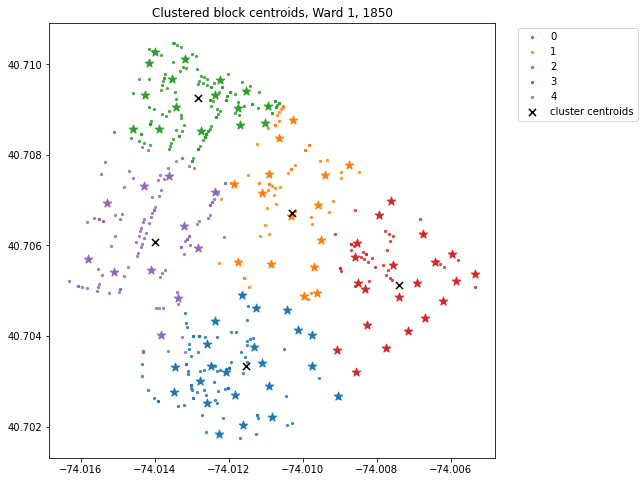

n is 5 and it's the 10th iteration


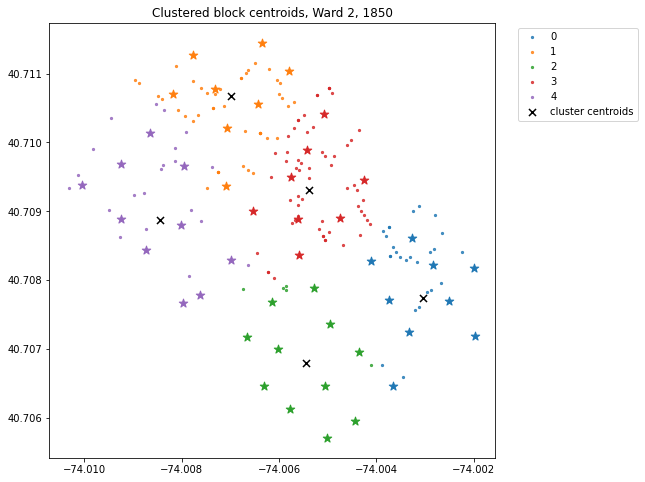

n is 5 and it's the 10th iteration


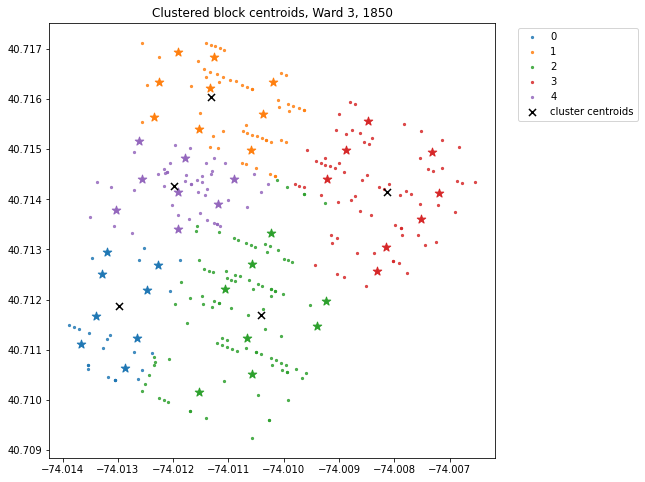

n is 5 and it's the 10th iteration


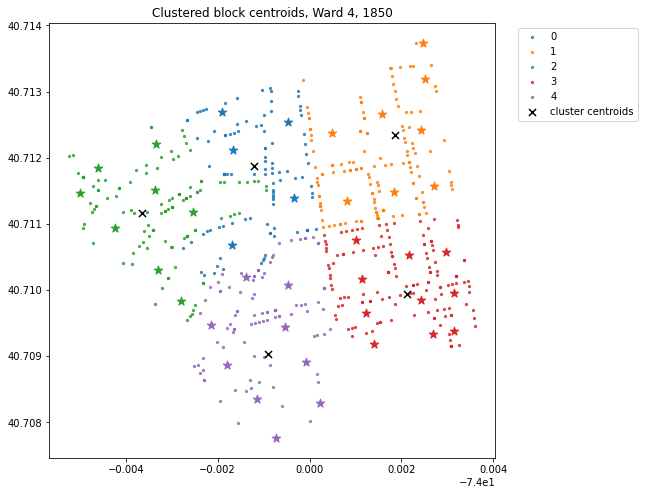

n is 5 and it's the 10th iteration


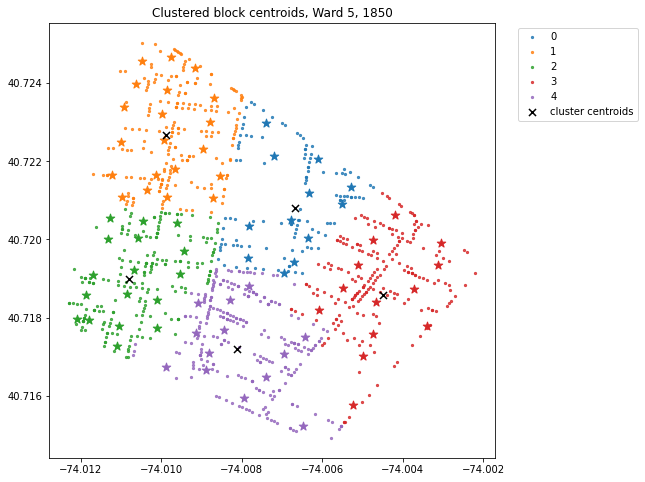

n is 5 and it's the 10th iteration


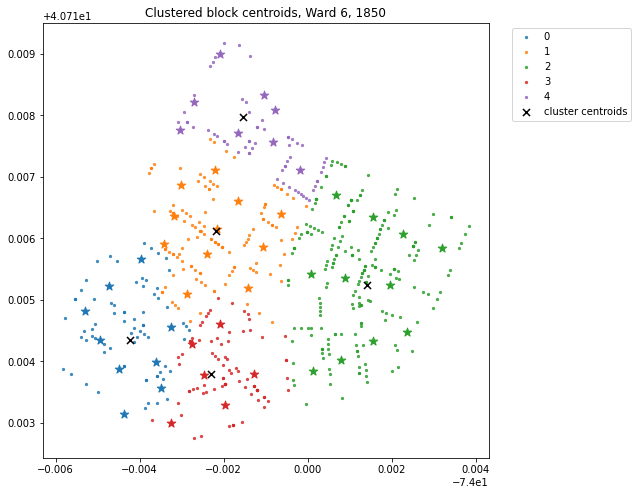

n is 5 and it's the 10th iteration


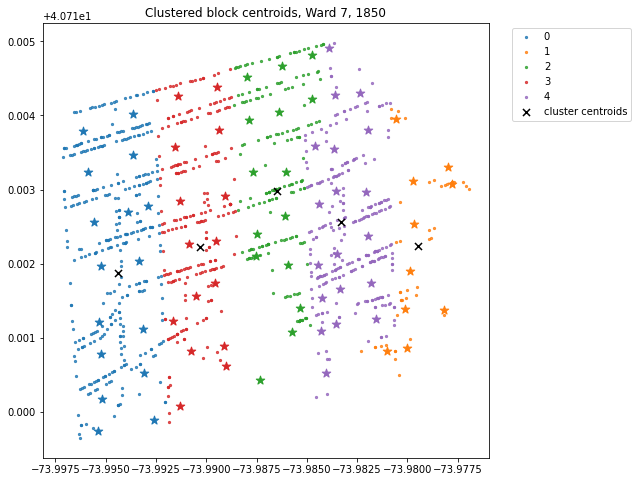

n is 5 and it's the 10th iteration


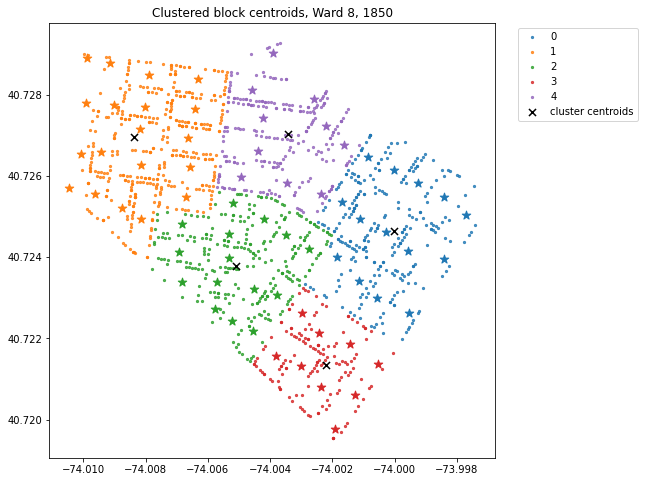

n is 5 and it's the 10th iteration


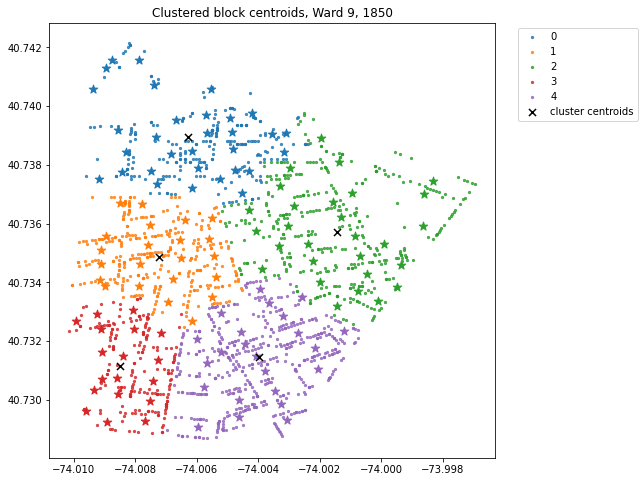

n is 5 and it's the 10th iteration


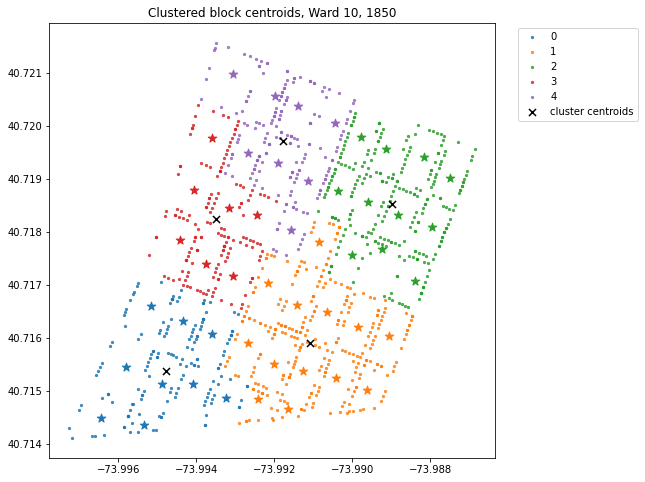

n is 5 and it's the 10th iteration


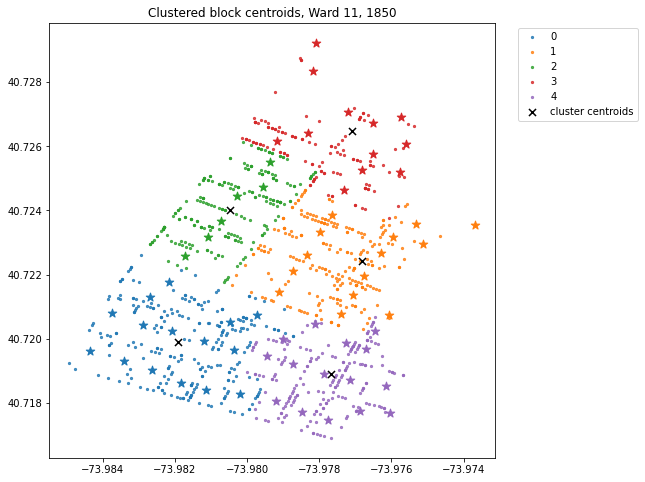

n is 5 and it's the 10th iteration


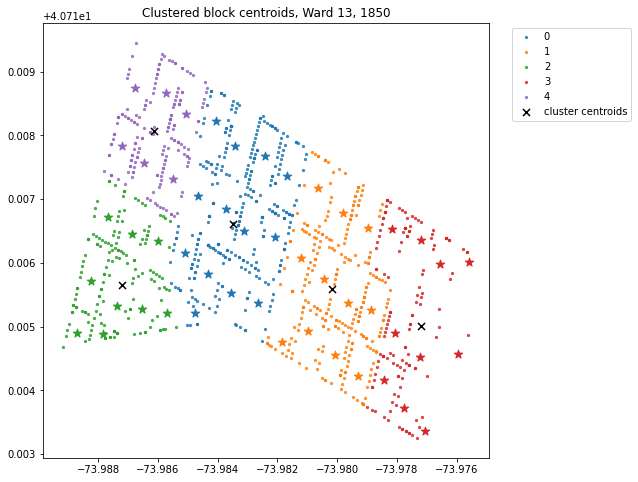

n is 5 and it's the 10th iteration


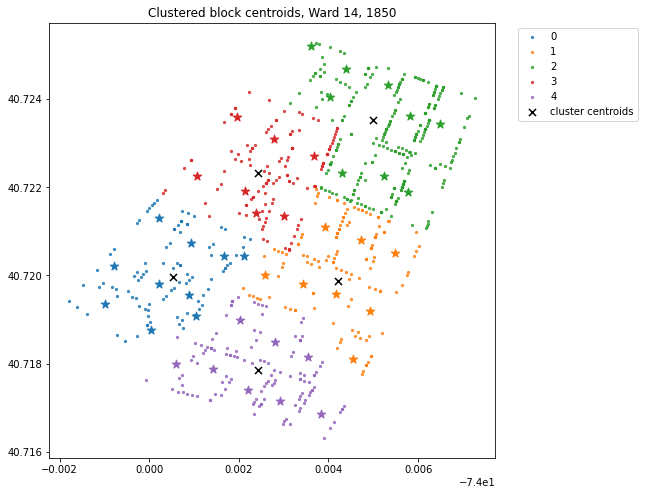

n is 5 and it's the 10th iteration


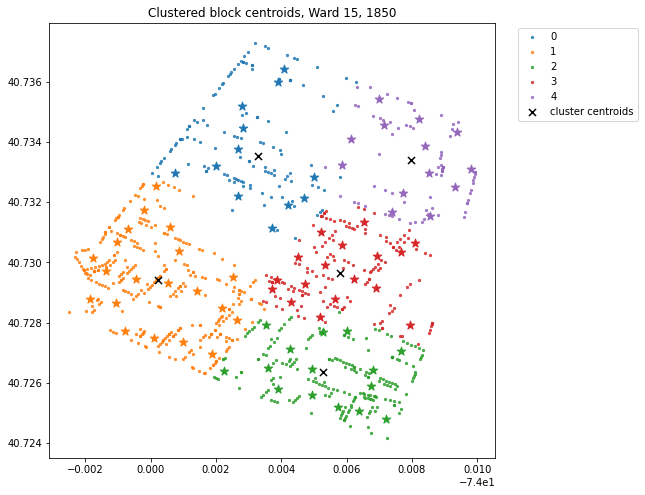

n is 5 and it's the 10th iteration


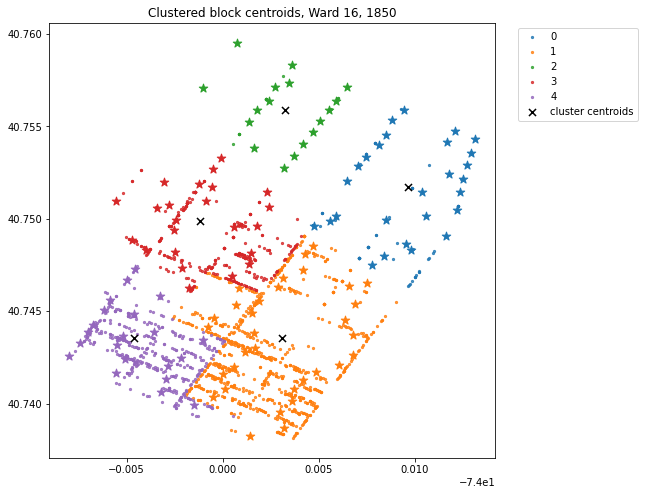

n is 5 and it's the 10th iteration


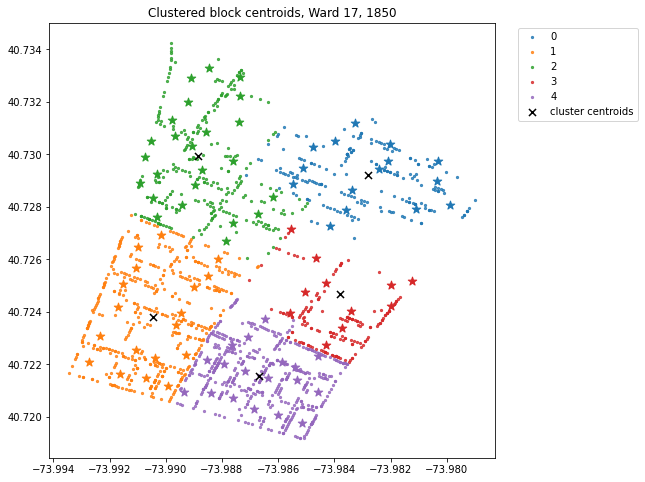

n is 5 and it's the 10th iteration


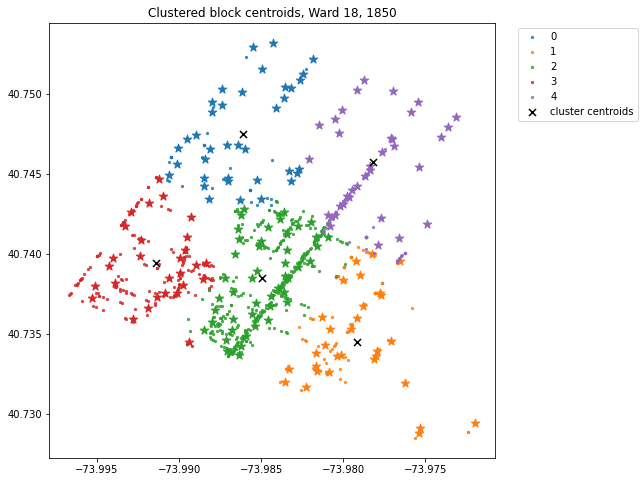

In [50]:
to_cluster_by_ward = {}
for current_ward in ward_list:
    
    ## run kmeans to get block clusters on data within current_ward
    interpolate_sequences = CentroidInterpolator(census_enum_seq, current_ward, 
                                                 pipeline, all_cols, KMeans(5), block_centroids)
    score, model = interpolate_sequences.kmeans_best(5)
    interpolate_sequences.set_clustering_algo(model)
    interpolate_sequences.apply_clustering(algo_fit = True)
    interpolate_sequences.clustervis(kmeans = True)
    
    ## get dictionary to encode from block number to cluster
    to_cluster = np.array(list(block_centroids[current_ward].values()))
    clusters = model.predict(to_cluster)
    block_num_to_cluster = {block_num: cluster for block_num, cluster in zip(block_centroids[current_ward].keys(), clusters)}

    to_cluster_by_ward[current_ward] = block_num_to_cluster
# Wall Clock: 5m34s

#### Assign block cluster to all dwellings

In [51]:
all_dwellings_3['cluster'] = [to_cluster_by_ward[ward][blocknum] \
                              if blocknum in to_cluster_by_ward[ward].keys() \
                              else np.nan for blocknum, ward in \
                              zip(all_dwellings_3[block_col], all_dwellings_3[ward_col])]

#### Overwrite the new data to census_enum_seq.df

Now `census_enum_seq.df` contains all dwellings, including dwellings with previously interpolated block numbers.

In [52]:
census_enum_seq.df = all_dwellings_3

#### Fill in distance sequence

* drop `enum_dist_id` column. It will be recreated later.

In [53]:
census_all_dwellings, dwellings_sequence_with_next_info \
    = interpolation_fillin.get_dwelling_with_fillin_info(census_enum_seq, ward_col, 
                                                         dwelling_col, sequence_unique_id)
## only check on sequence col
all_dwellings_dist_seq = dataprocessing.all_dwellings_sequenced(census_all_dwellings, dwellings_sequence_with_next_info, 
                                                       fill_column = sequence_unique_id,
                                                       check_column = ['cluster', sequence_unique_id], ward_col = ward_col, 
                                                              dwelling_col = dwelling_col)
## remove helper columns as mentioned at the top of the notebook
## Drop `enum_dist_id`. To be created later
all_dwellings_dist_seq.drop(columns = ['header', sequence_unique_id + "_next", 'num_between_real'], 
                     inplace=True)
#if 'enum_dist_id' in all_dwellings_dist_seq.columns:
#  all_dwellings_dist_seq.drop(columns = ['enum_dist_id'], inplace = True)
# Wall Clock: 55s

#### Combine new distance and enumeration distance sequence dfs

In [54]:
all_dwellings_filled_seq = all_dwellings_dist_seq.copy()

#### Label dwellings with filled in sequences

In [55]:
## with sequence id but no block num
all_dwellings_filled_seq['filled_sequence_id'] = \
    np.where(~all_dwellings_filled_seq[sequence_unique_id].isnull() &\
            all_dwellings_filled_seq[block_col].isnull(), 1, 0)

## with enum dist id but no block num
all_dwellings_filled_seq['filled_enum_dist_id'] = \
    np.where(~all_dwellings_filled_seq["enum_dist_id"].isnull() &\
            all_dwellings_filled_seq[block_col].isnull(), 1, 0)

#### 4. Report result at dwelling level

In [56]:
total_dwellings = all_dwellings_filled_seq.groupby(ward_col)['dwelling_id'].agg('count')
known_dwellings = all_dwellings_filled_seq.groupby(ward_col)['known_address'].agg('sum')
filled_block_num_dwellings = all_dwellings_filled_seq.groupby(ward_col)['filled_block_num'].agg('sum')
filled_distance_seq_dwellings = all_dwellings_filled_seq.groupby(ward_col)['filled_sequence_id'].agg('sum')
filled_enum_dist_seq_dwellings = all_dwellings_filled_seq.groupby(ward_col)['filled_enum_dist_id'].agg('sum')
left_over = all_dwellings_filled_seq.loc[(all_dwellings_filled_seq[block_col].isnull()) & 
                     ((all_dwellings_filled_seq['filled_sequence_id'] == 0) | 
                      (all_dwellings_filled_seq['filled_enum_dist_id'] == 0))].groupby(ward_col)['dwelling_id'].agg('count')

In [57]:
## distance seq is always interpolated if enum_dist seq is. Must be 0.
all_dwellings_filled_seq.loc[(all_dwellings_filled_seq['filled_sequence_id'] == 0) & (all_dwellings_filled_seq['filled_enum_dist_id'] == 1)].shape[0]

0

In [58]:
report = pd.DataFrame([known_dwellings, filled_block_num_dwellings, 
                       filled_distance_seq_dwellings, filled_enum_dist_seq_dwellings, 
                       left_over])/total_dwellings*100
report = report.T
report.rename(columns={'dwelling_id': 'left_over'}, inplace=True)
report['complete_seq'] = report['filled_enum_dist_id']
report['only_distance_seq'] = report['filled_sequence_id'] - report['filled_enum_dist_id']

In [59]:
report

,known_address,filled_block_num,filled_sequence_id,filled_enum_dist_id,left_over,complete_seq,only_distance_seq
CENSUS_WARD_NUM,,,,,,,
1,36.372093,6.976744,12.465116,0.0,56.651163,0.0,12.465116
2,23.692308,5.692308,11.846154,0.0,70.615385,0.0,11.846154
3,39.671683,12.175103,12.311902,0.0,48.153215,0.0,12.311902
4,47.325770,13.857374,5.996759,0.0,38.816856,0.0,5.996759
5,47.677866,17.243083,8.003953,0.0,35.079051,0.0,8.003953
6,39.700641,14.183892,10.334996,0.0,46.115467,0.0,10.334996
7,41.523734,15.676107,9.014759,0.0,42.800160,0.0,9.014759
8,48.506919,17.589221,7.938820,0.0,33.903860,0.0,7.938820
9,46.422438,14.739554,11.934745,0.0,38.838008,0.0,11.934745


Text(0, 0.5, '%')

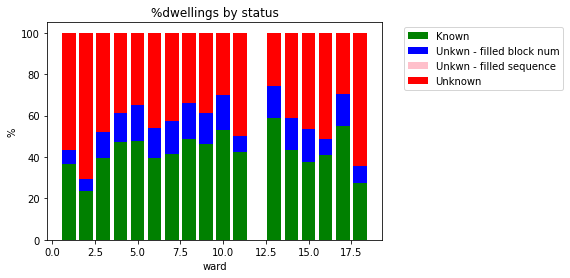

In [60]:
fig, ax = plt.subplots(1,1)

p1 = ax.bar(ward_list, report['known_address'], color='g')
p2 = ax.bar(ward_list, report['filled_block_num'], 
       bottom=report['known_address'], color='b')
p3 = ax.bar(ward_list, report['complete_seq'], 
       bottom=report['known_address'] + report['filled_block_num'], color='pink')
p4 = ax.bar(ward_list, report['left_over'], 
       bottom=report['known_address'] + report['filled_block_num'] + report['complete_seq'], color='r')
ax.legend([p1,p2,p3,p4], ['Known','Unkwn - filled block num', 
                          'Unkwn - filled sequence','Unknown'],
         bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_title('%dwellings by status')
ax.set_xlabel('ward')
ax.set_ylabel('%')

#### 5. Turn into record-level and export data

In [61]:
all_dwellings_filled_seq.columns

Index(['CENSUS_WARD_NUM', 'dwelling_id', 'CD_H_ADDRESS', 'CD_STREET_ID',
       'CD_X', 'CD_Y', 'CENSUS_AGE', 'CENSUS_CITY', 'CENSUS_DWELLING_NUM',
       'CENSUS_DWELLING_SEQ', 'CENSUS_DWELLING_SIZE', 'CENSUS_FIRST_NAME',
       'CENSUS_GENDER', 'CENSUS_GEOG', 'CENSUS_HH_NUM', 'CENSUS_IMPREL',
       'CENSUS_INDEX', 'CENSUS_IPUMS_UID', 'CENSUS_LABFORCE',
       'CENSUS_LAST_NAME', 'CENSUS_LINE', 'CENSUS_MARST', 'CENSUS_OCCUPATION',
       'CENSUS_PAGENUM', 'CENSUS_RACE', 'CENSUS_REEL', 'CENSUS_SEQ_NUM',
       'CENSUS_SERIAL', 'spatial_weight', 'spatial_weight_sum',
       'page_sequence_id', 'PLACE', 'CENSUS_ENUMERATOR_NUM',
       'CENSUS_ENUMERATOR_DATE', 'ANCESTRY_REF', 'CENSUS_REEL_HOUSEHOLD',
       'enum_dist_id', 'enum_dist', 'enum_dist_order', 'enum_sequence_len',
       'num_between', 'dwelling_seq_id', 'CD_BLOCK_NUM', 'filled_block_num',
       'known_address', 'cluster', 'enum_seq', 'filled_sequence_id',
       'filled_enum_dist_id'],
      dtype='object')

In [62]:
# Have not added CD_H_Address, CD_X and CD_Y at this point because they have not been used 
# Should consider adding that in the future 
selected_columns = ['CENSUS_WARD_NUM', 'dwelling_id',
                   'CENSUS_ENUMERATOR_NUM', 'CENSUS_ENUMERATOR_DATE', 'ANCESTRY_REF', 
                   'enum_seq', 'filled_sequence_id', 
                    'CD_BLOCK_NUM', 'filled_block_num', 
                    'enum_dist', 'enum_dist_order', 'enum_dist_id',
                    'enum_sequence_len', 'num_between', 'dwelling_seq_id']
all_dwellings_filled_seq_selected = all_dwellings_filled_seq[selected_columns]

In [63]:
census_1850_filled_seq = filled_1850.merge(all_dwellings_filled_seq_selected, on = ['CENSUS_WARD_NUM', 'dwelling_id'], how = "left")
census_1850_filled_seq['CD_BLOCK_NUM'] = census_1850_filled_seq['CD_BLOCK_NUM_x']
census_1850_filled_seq.loc[(census_1850_filled_seq['CD_BLOCK_NUM_x'].isnull()) & (census_1850_filled_seq['filled_block_num'] == 1), 'CD_BLOCK_NUM'] = census_1850_filled_seq['CD_BLOCK_NUM_y']
census_1850_filled_seq = census_1850_filled_seq.drop(['CD_BLOCK_NUM_x', 'CD_BLOCK_NUM_y'], axis = 1)

In [64]:
census_1850_filled_seq.head(3)

,CD_H_ADDRESS,CD_STREET_ID,CD_X,CD_Y,CENSUS_AGE,CENSUS_CITY,CENSUS_DWELLING_NUM,CENSUS_DWELLING_SEQ,CENSUS_DWELLING_SIZE,CENSUS_FIRST_NAME,CENSUS_GENDER,CENSUS_GEOG,CENSUS_HH_NUM,CENSUS_IMPREL,CENSUS_INDEX,CENSUS_IPUMS_UID,CENSUS_LABFORCE,CENSUS_LAST_NAME,CENSUS_LINE,CENSUS_MARST,CENSUS_OCCUPATION,CENSUS_PAGENUM,CENSUS_RACE,CENSUS_REEL,CENSUS_SEQ_NUM,CENSUS_SERIAL,CENSUS_WARD_NUM,dwelling_id,spatial_weight,spatial_weight_sum,CENSUS_ENUMERATOR_NUM,CENSUS_ENUMERATOR_DATE,ANCESTRY_REF,enum_seq,filled_sequence_id,filled_block_num,enum_dist,enum_dist_order,enum_dist_id,enum_sequence_len,num_between,dwelling_seq_id,CD_BLOCK_NUM
0,25 SOUTH ST,NaN,-74.009014,40.702622,49,MANHATTAN,1.0,1.0,84,JOHN M,1,NEW YORK WARD 1 EASTERN DIVISION,401735,1,1,1a0cea81-aa4c-4e02-af29-37f3fdadd987,2,FLINT,10,6,INN KEEPER,7,120,534,1,2044262,1,1,NaN,NaN,e01,1850/09/12,4189775.0,1.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,m00010
1,25 SOUTH ST,NaN,-74.009014,40.702622,36,MANHATTAN,1.0,1.0,84,MARY A,2,NEW YORK WARD 1 EASTERN DIVISION,401735,1,2,29aed4d0-b649-4d6b-9e28-3db8f4da81d8,0,FLINT,10,6,NaN,7,120,534,2,2044263,1,1,NaN,NaN,e01,1850/09/12,4189775.0,1.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,m00010
2,25 SOUTH ST,NaN,-74.009014,40.702622,12,MANHATTAN,1.0,1.0,84,MARY D,2,NEW YORK WARD 1 EASTERN DIVISION,401735,1,3,8cfac447-5fdf-44a4-888c-ee1c7e2a8355,0,FLINT,10,6,NaN,7,120,534,3,2044264,1,1,NaN,NaN,e01,1850/09/12,4189775.0,1.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,m00010


In [65]:
# if the sequence is filled during the modeling part before, return 1, otherwise, null values
def sequence_filled(row, sequence_col):
  if pd.isnull(row[sequence_col]) == False: 
    return 1
  else:
    return 0
census_1850_filled_seq['sequence_filled'] = census_1850_filled_seq.apply (lambda row: sequence_filled(row, sequence_unique_id), axis=1)

### Fill out the missing sequence id for only enumerator sequence

In [66]:
sequence_id = census_1850_filled_seq[sequence_unique_id]
sequence_filled = census_1850_filled_seq['sequence_filled']
small_df = census_1850_filled_seq[[sequence_unique_id, 'sequence_filled', 
                                   'CENSUS_ENUMERATOR_NUM', 'CENSUS_ENUMERATOR_DATE']].copy()
fill_id = max(sequence_id) + 1
for i in range(len(small_df)):
  record = small_df.iloc[i]
  if sequence_filled[i] != 1:
    fill_value = sequence_id_dict.get((record['CENSUS_ENUMERATOR_NUM'], record['CENSUS_ENUMERATOR_DATE'], "enum_seq"))
    if fill_value is None:
      sequence_id[i] = fill_id
      sequence_id_dict[(record['CENSUS_ENUMERATOR_NUM'], record['CENSUS_ENUMERATOR_DATE'], "enum_seq")] = fill_id
      fill_id += 1
    else:
      sequence_id[i] = fill_value
    #sequence_id[i] = sequence_id_dict.get((record['CENSUS_ENUMERATOR_NUM'], record['CENSUS_ENUMERATOR_DATE'], "enum_seq"))

census_1850_filled_seq[sequence_unique_id] = sequence_id
census_1850_filled_seq["sequence_filled"] = sequence_filled

# Wall Clock: 1m48s

### New Experimental Step: Street id Prediction

The street id prediction mimics the process of block number prediction, starting from the step of sequence generation. The end products of the following steps, including a column of street id prediction and a column indicating the action of prediction, would be added to the dataframe created during the previous steps. As for the current step, the street id and block number prediction is separate. However, the combination of those two results would become helpful in predicting complete address information for census records considering the geographical relationship between block and street. 

In [67]:
census_enum_seq_street = CensusData(census_enumerators, ward_col=ward_col, dwelling_col=dwelling_col, 
                             block_col =  block_col, x_col = x_col, y_col = y_col, pagenum = pagenum)

sequences_dfs_street = census_enum_seq_street.applying_sequencing_only_enum(target_column = "CD_STREET_ID")
# 34s

In [68]:
census_all_dwellings_street, dwellings_sequence_with_next_info_street \
    = interpolation_fillin.get_dwelling_with_fillin_info(census_enum_seq_street, ward_col, 
                                                         dwelling_col, "CD_STREET_ID")

dwellings_sequence_with_next_info_street.loc[dwellings_sequence_with_next_info_street[ward_col].isnull()].shape

(0, 47)

In [69]:
all_dwellings_3_street = dataprocessing.all_dwellings_sequenced(census_all_dwellings_street, 
                                                         dwellings_sequence_with_next_info_street,
                                                         fill_column = "CD_STREET_ID",
                                                         check_column = ["CD_STREET_ID", sequence_unique_id], 
                                                         ward_col = ward_col, 
                                                         dwelling_col = dwelling_col)

## remove helper columns as mentioned at the top of the notebook
all_dwellings_3_street.drop(columns = ['header', 'CD_STREET_ID_next', 'num_between_real'], 
                     inplace=True)


In [70]:
filled_street_num = all_dwellings_3_street.loc[~(all_dwellings_3_street['CD_STREET_ID'].isnull()) & (all_dwellings_3_street[sequence_unique_id].isnull())].shape[0]
unknown_dwelling_street = all_dwellings_3_street.loc[(all_dwellings_3_street[sequence_unique_id].isnull())].shape[0]
total_dwelling_street = all_dwellings_3_street.shape[0]
print('Total Dwelling: ', total_dwelling_street)
print('Total Unknown Dwelling: ', unknown_dwelling_street)
print('Total Dwelling with filled street number: ', filled_street_num)

Total Dwelling:  38560
Total Unknown Dwelling:  23286
Total Dwelling with filled street number:  3649


In [71]:
# Label the column where street id is filled 
all_dwellings_3_street['filled_street_num'] = np.where((~all_dwellings_3_street["CD_STREET_ID"].isnull()) &
                                              (all_dwellings_3_street[sequence_unique_id].isnull()), 1, 0)


In [72]:
all_dwellings_3_street = all_dwellings_3_street.loc[all_dwellings_3_street[ward_col] != 12]
all_dwellings_3_street = all_dwellings_3_street.loc[all_dwellings_3_street[ward_col] != 19]

In [73]:
# Add the updated Street id column and the indicator column to the output dataframe 
all_dwellings_street_selected = all_dwellings_3_street[[ward_col, dwelling_col, "CD_STREET_ID", 'filled_street_num']]
census_1850_street = filled_1850.merge(all_dwellings_street_selected, on = ['CENSUS_WARD_NUM', 'dwelling_id'], how = "left")
census_1850_street = census_1850_street.drop("CD_STREET_ID_x", axis = 1)
census_1850_street = census_1850_street.rename(columns={"CD_STREET_ID_y": "CD_STREET_ID"})

street_id = census_1850_street['CD_STREET_ID']
street_id_indicator = census_1850_street['filled_street_num']

census_1850_filled_seq['CD_STREET_ID'] = street_id
census_1850_filled_seq['filled_street_num'] = street_id_indicator

In [74]:
print("Proportion of missing street ids in the original census records: ", 
      len(filled_1850[filled_1850['CD_STREET_ID'].isnull()])/len(filled_1850))
print("Proportion of missing street ids in the original census records after street id prediction: ", 
      len(census_1850_filled_seq[census_1850_filled_seq['CD_STREET_ID'].isnull()])/len(census_1850_filled_seq))

Proportion of missing street ids in the original census records:  0.9564319376296957
Proportion of missing street ids in the original census records after street id prediction:  0.41720807555805517


In [75]:
print("Proportion of records without any address info (block or street): ",
      1-len(filled_1850[(filled_1850['CD_STREET_ID'].isnull() == False) | (filled_1850['CD_BLOCK_NUM'].isnull() == False)])/len(filled_1850))
print("Proportion of records without any address info (block or street) after prediction: ", 
      1-len(census_1850_filled_seq[(census_1850_filled_seq['CD_STREET_ID'].isnull() == False) | (census_1850_filled_seq['CD_BLOCK_NUM'].isnull() == False)])/len(census_1850_filled_seq))

Proportion of records without any address info (block or street):  0.47951438046661365
Proportion of records without any address info (block or street) after prediction:  0.37470085138568354


#### Address Name and No. prediction based on street id and block prediction

street name prediction:
1. look at the first and last word of the string 
2. Predict the part after or before the number 

Sanity check of merging.

In [76]:
assert census_1850_filled_seq.shape[0] == filled_1850.shape[0], 'not properly merged'

In [77]:
census_1850_filled_seq.to_csv(output_file_path, index=False)